In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
import copy
import numpy as np
import pandas as pd
import math
from scipy import stats
import re
from matplotlib import pyplot as plt
import matplotlib.cm as mpcm
import function as func
np.set_printoptions(threshold=20)

plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

In [2]:
inputdir = 'input/Design6_scan6'
inputfile_list = ['ReturnLoss_H.csv', 'ReturnLoss_V.csv']

# Read HFSS data

In [3]:
def read_HFSS_data(inputdir=inputdir, inputfile_list=inputfile_list, verbose=1):
    # Read the data to data_list (pandas list)
    data_list = []

    for _file in inputfile_list:
        _d = func.csv_to_array(f'{inputdir}/{_file}')
        # Rename Keys  (Remove unit)
        _keys = list(_d.keys())
        for _k in _keys:
            _new_key = re.sub('\[.*\]', '', _k)
            _new_key = _new_key.strip()

            if verbose > 0:
                print(_new_key)
                pass
            _d[_new_key] = _d.pop(_k)
            pass
        # Search for dB key
        _new_keys = list(_d.keys())
        _dB_keys = []
        for _k in _new_keys:
            if _k.startswith('dB'):
                _dB_keys.append(_k)
                pass
            pass
        if len(_dB_keys) == 1:
            _d['Power'] = _d.pop(_dB_keys[0])
        else:
            print(f'WARNING!!: There are several power columns!')
            print(f'WARNING!!: keys = {_dB_keys}')
            pass

        data_list.append(pd.DataFrame(_d))
        pass
    if verbose > 0:
        print(data_list[0])
        print(data_list[0].keys())
        print(data_list[0]['Freq'])
        pass
    
    return data_list

data_list = read_HFSS_data(inputdir=inputdir, inputfile_list=inputfile_list)

by1
by2
bz1
bz2
C1
CX1
CX2
CX3
cy0
cy1
cy2
cy3
JR1
JR2
Jx2
Jy1
Jy4
mc
s
Vx1
vx2
vy1
vy2
vy3
vy4
Vz
vz2
vz3
wx
wx_l1
ys0
ys1
ys2
ys3
ys4
yy2
zs1
zs2
zs3
zs4
Freq
dB(S(1:2,1:2))
by1
by2
bz1
bz2
C1
CX1
CX2
CX3
cy0
cy1
cy2
cy3
JR1
JR2
Jx2
Jy1
Jy4
mc
s
Vx1
vx2
vy1
vy2
vy3
vy4
Vz
vz2
vz3
wx
wx_l1
ys0
ys1
ys2
ys3
ys4
yy2
zs1
zs2
zs3
zs4
Freq
dB(S(1:1,1:1))
       by1    by2    bz1    bz2     C1    CX1    CX2    CX3   cy0    cy1  ...  \
0     0.42  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494  ...   
1     0.42  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494  ...   
2     0.42  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494  ...   
3     0.42  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494  ...   
4     0.42  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494  ...   
...    ...    ...    ...    ...    ...    ...    ...    ...   ...    ...  ...   
7671  0.42  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494  ...   


In [4]:
def plot_all(data_list=data_list, inputfile_list=inputfile_list):
    fig = plt.figure(figsize=(12,6))
    for _f, _data in zip(inputfile_list, data_list):
        plt.plot(_data['Freq'], _data['Power'], label=_f)
        plt.legend(frameon=False)
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Return Loss [dB]')
        plt.grid(True)
        pass
    fig.tight_layout()
    return 0

#plot_all(data_list=data_list, inputfile_list=inputfile_list)

In [5]:
def separate_parset(data_list=data_list, inputfile_list=inputfile_list, doPlot=True):

    #### Separate data with different parameters ####
    
    par_list_list = []
    parset_list_list = []
    nominal_parset_list = []
    freq_data_list_list = []
    nominal_freq_data_list = []
    groupby_list = []
    
    for _data in data_list:
        _freq_data_list = []

        _keys = _data.keys().tolist()
        #print(_keys)
        _keys.remove('Power')
        _keys.remove('Freq')
        #print('Power' in _keys)
        _keys_except_freq_dB = _keys
        _groupby = _data.groupby(_keys_except_freq_dB)
        _groups = _groupby.groups
        _group_keys = list(_groups.keys())
        # Get a list of parameter set
        _parset_list = pd.DataFrame(list(_group_keys), columns=_keys_except_freq_dB)
        # Get nominal parameter values from mode
        print(f'parset_list shape = {_parset_list.shape}')
        _nominal_parset = np.array(stats.mode(_parset_list, axis=0).mode[0])
        print(f'_nominal_parset{_nominal_parset.shape} = {_nominal_parset}')
        #print(_groups[_group_keys[0]])
        #print(type(_groups[_group_keys[0]]))

        for _gk in _group_keys:
            _group_data = _groupby.get_group(_gk)
            _freq_data_list.append( _group_data )
            if np.all( np.array(_gk) == _nominal_parset ):
                nominal_freq_data_list.append(_group_data)
                pass
            pass

        par_list_list.append( _keys_except_freq_dB )
        parset_list_list.append( _parset_list )
        nominal_parset_list.append(_nominal_parset)
        freq_data_list_list.append( _freq_data_list )
        groupby_list.append( _groupby )
        print(f'par_list ({len(par_list_list[-1])}) = {par_list_list[-1]}')
        print(f'nominal_parset = {nominal_parset_list[-1]}')
        print(f'parset_list example: {np.array(parset_list_list[-1].iloc[0, :])}')
        print(f'freq_data_list size = {len(freq_data_list_list[-1])}')
        pass

    if len(nominal_freq_data_list) != len(data_list):
        print('ERROR!! Failed to get the nominal frequency data list (Its number is different from number of data)')
        print(f'ERROR!! # of data = {len(data_list)}')
        print(f'ERROR!! # of nominal data = {len(nominal_freq_data_list)}')
        pass

    
    #### Plot frequency spectra ####

    if doPlot:
        for _f, _freq_data_list in zip(inputfile_list, freq_data_list_list):
            fig = plt.figure(figsize=(12,6))
            for i, _data in enumerate(_freq_data_list):
                plt.plot(_data['Freq'], _data['Power'], label=f"{i}")
                #plt.legend(frameon=False)
                pass
            plt.xlabel('Frequency [GHz]')
            plt.ylabel('Return Loss [dB]')
            plt.grid(True)
            fig.tight_layout()
            pass
        pass

    
    #### Get indices of the spectra for a specific varing parameter ####

    index_3Dlist = []
    for m, (_f, _freq_data_list) in enumerate(zip(inputfile_list, freq_data_list_list)): 
        print(f'========== {_f} =============')
        _par_list = par_list_list[m]
        _parset_list = parset_list_list[m]
        _nominal_parset = np.array(nominal_parset_list[m])
        print(_nominal_parset)
        print(np.array(_par_list).shape)
        _nominal_parset_pd = pd.Series(_nominal_parset, index=_par_list)

        fig_ncol = 4
        fig_nrow = math.ceil( len(_par_list)/fig_ncol ) # 小数点以下切り上げ
        fig, axs = plt.subplots(fig_nrow, fig_ncol, figsize=(4*fig_ncol, 3*fig_nrow))
        fig.suptitle(_f)

        # Loop over changing parameter
        _index_list_list = []
        for n, _par in enumerate(_par_list):
            _fig_icol = n%fig_ncol
            _fig_irow = int(n/fig_ncol)
            _ax = axs[_fig_irow, _fig_icol]

            # Parameters except the changing parameter
            _pars_except = copy.copy(_par_list)
            _pars_except.remove(_par)
            _pars_index_except = [ i for i in range(len(_par_list)) if (_par_list[i] in _pars_except) ]
            #print(_pars_index)

            _nominal_parset_except = _nominal_parset[_pars_index_except]
            #print(_nominal_parset_except.shape)
            #print(_parset_list)
            _index_list = []
            for i, _row in _parset_list.iterrows():
                #print(type(_row))
                _row_array = np.array(_row)
                #print(_row_array.shape)
                
                # check varied only 1 parameter (_par)
                if np.all( _row_array[_pars_index_except] == _nominal_parset_except ):
                    
                    if doPlot:
                        # Plot power spectra for each parameter
                        
                        #print(f"Found target parset! (changing par = {_par} / {len(_index_list)})")
                        _par_value = _row[_par]
                        _data = _freq_data_list[i]
                        if np.all( _row_array == _nominal_parset ):
                            _ax.plot(_data['Freq'], _data['Power'], label=f'{_par} = {_par_value}', lw=1.5, c='black')
                        else:
                            _ax.plot(_data['Freq'], _data['Power'], label=f'{_par} = {_par_value}')
                            pass
                        pass

                    # Save the index
                    _index_list.append( i )
                    pass 
                pass # End of loop over parset_list (changed parameter set list)
            
            if doPlot:
                _ax.legend(frameon=False, fontsize=8)
                _ax.set_xlabel('Frequency [GHz]')
                _ax.set_xlim([165, 265])
                _ax.set_ylabel('Power [dB]')
                _ax.set_ylim([-30, -15])
                _ax.set_title(f'{_par}')
                _ax.grid(True)
                pass
            
            _index_list_list.append(_index_list)
            pass

        if doPlot: fig.tight_layout(rect=[0,0,1,0.96])
            
        index_3Dlist.append(_index_list_list)
        pass

    print(f'index_3Dlist = {index_3Dlist}')
    
    returns = [0]*10
    returns[0] = par_list_list
    returns[1] = parset_list_list
    returns[2] = freq_data_list_list
    returns[3] = nominal_parset_list
    returns[4] = nominal_freq_data_list
    returns[5] = index_3Dlist
    
    return returns

# Plot HFSS data

## Functions

### plot_parameters()

In [6]:
def plot_parameters(freq_data_2Dlist, index_3Dlist, par_2Dlist, parset_2Dlist, 
                    nominal_parset_list, inputfile_list=inputfile_list, showMean=True, verbose=0):
    
    nominal_mean_list = []
    nominal_max_list = []
    diff_mean_up_3Dlist = []
    diff_mean_down_3Dlist = []
    diff_max_up_3Dlist = []
    diff_max_down_3Dlist = []
    diff_par_up_3Dlist = []
    diff_par_down_3Dlist = []
    for m, (_f, _freq_data_list) in enumerate(zip(inputfile_list, freq_data_2Dlist)): 
        print(f'========== {_f} =============')
        _index_2Dlist = index_3Dlist[m]
        _par_list = par_2Dlist[m]
        _parset_list = parset_2Dlist[m]
        _nominal_parset = np.array(nominal_parset_list[m])

        fig, axs = plt.subplots(2, 1, figsize=(15, 6))
        fig.suptitle(_f)

        print(f'Paramters = {_par_list}')

        # Get nominal values
        _nominal_mean = None
        _nominal_max = None
        # Check 0th parameter varing
        for i in _index_2Dlist[0]:
            _nominal_par_value = _nominal_parset[0]
            _parset = np.array( _parset_list.iloc[i, ] )
            _par_value = _parset[0]
            if _nominal_par_value == _par_value:
                _power = _freq_data_list[i]['Power']
                _mean = func.ratio_to_dB( np.mean(func.dB_to_ratio(_power)) )
                _max = max(_power)
                _nominal_mean = _mean
                _nominal_max = _max
                break
            pass
        
        _diff_mean_up_2Dlist = []
        _diff_mean_down_2Dlist = []
        _diff_max_up_2Dlist = []
        _diff_max_down_2Dlist = []
        _diff_par_up_2Dlist = []
        _diff_par_down_2Dlist = []
        # Loop over changing parameter
        for n, (_par, _index_list) in enumerate(zip(_par_list, _index_2Dlist)):
            #print(f'Varying parameter = {_par}')
            _i_par = np.where( np.array(_par_list) == _par)[0][0]
            #print(f'Parameter index = {_i_par}')
            _nominal_par_value = _nominal_parset[_i_par]
            
            _diff_mean_up_list = []
            _diff_mean_down_list = []
            _diff_max_up_list = []
            _diff_max_down_list = []
            _diff_par_up_list = []
            _diff_par_down_list = []
            for i in _index_list:
                _power = _freq_data_list[i]['Power']
                #print(type(_freq_data))
                #print(_freq_data)
                _parset = np.array(_parset_list.iloc[i, ])
                _par_value = _parset[_i_par]
                _row = _parset_list.iloc[i, ]
                _row_array = np.array(_row)
                #print(f'nominal value = {_nominal_par_value} / varied value = {_par_value}')
                #print(_row_array.shape)

                if np.all( _row_array == _nominal_parset ):
                    isNominal = True
                else:
                    isNominal = False
                    pass

                _mean = func.ratio_to_dB( np.mean(func.dB_to_ratio(_power)) )
                _max = max(_power)
                if isNominal:
                    axs[0].scatter([_par], [_mean], c=func.colors[n], marker='o', label='Nominal' if n==0 else None)
                    axs[1].scatter([_par], [_max], c=func.colors[n], marker='o', label='Nominal' if n==0 else None)
                elif _par_value < _nominal_par_value:
                    axs[0].scatter([_par], [_mean], c=func.colors[n], marker='v', label='Down' if n==0 else None)
                    axs[1].scatter([_par], [_max], c=func.colors[n], marker='v', label='Down' if n==0 else None)
                    _diff_mean_down_list.append( _mean - _nominal_mean )
                    _diff_max_down_list.append( _max - _nominal_max )
                    _diff_par_down_list.append( _par_value )
                else:
                    axs[0].scatter([_par], [_mean], c=func.colors[n], marker='^', label='Up' if n==0 else None)
                    axs[1].scatter([_par], [_max], c=func.colors[n], marker='^', label='Up' if n==0 else None)
                    _diff_mean_up_list.append( _mean - _nominal_mean )
                    _diff_max_up_list.append( _max - _nominal_max )
                    _diff_par_up_list.append( _par_value )
                    pass
                
                pass # End of loop over indices
            
            _diff_mean_up_2Dlist.append( _diff_mean_up_list )
            _diff_mean_down_2Dlist.append( _diff_mean_down_list )
            _diff_max_up_2Dlist.append( _diff_max_up_list )
            _diff_max_down_2Dlist.append( _diff_max_down_list )
            _diff_par_up_2Dlist.append( _diff_par_up_list )
            _diff_par_down_2Dlist.append( _diff_par_down_list )
            pass # End of loop over parameters

        axs[0].tick_params(axis = 'x', labelsize=12, rotation=45)
        axs[0].set_xlabel('Varied Parameter')
        axs[0].set_ylabel('Average Power [dB]')
        axs[0].set_xlim([0, len(_par_list)])
        axs[0].set_ylim([-30, -15])
        axs[0].grid(True)
        axs[0].legend(frameon=False)

        axs[1].tick_params(axis = 'x', labelsize=12, rotation=45)
        axs[1].set_xlabel('Varied Parameter')
        axs[1].set_ylabel('Max Power [dB]')
        axs[1].set_xlim([0, len(_par_list)])
        axs[1].set_ylim([-30, -15])
        axs[1].grid(True)
        axs[1].legend(frameon=False)

        fig.tight_layout(rect=[0,0,1,0.96])
        
        nominal_mean_list.append(_nominal_mean)
        nominal_max_list.append(_nominal_max)
        diff_mean_up_3Dlist.append(_diff_mean_up_2Dlist)
        diff_mean_down_3Dlist.append(_diff_mean_down_2Dlist)
        diff_max_up_3Dlist.append(_diff_max_up_2Dlist)
        diff_max_down_3Dlist.append(_diff_max_down_2Dlist)
        diff_par_up_3Dlist.append(_diff_par_up_2Dlist)
        diff_par_down_3Dlist.append(_diff_par_down_2Dlist)
        pass
    
    returns = [0]*10
    returns[0] = nominal_mean_list
    returns[1] = nominal_max_list
    diffs = {}
    diffs['mean_up'] = diff_mean_up_3Dlist
    diffs['mean_down'] = diff_mean_down_3Dlist
    diffs['max_up'] = diff_max_up_3Dlist
    diffs['max_down'] = diff_max_down_3Dlist
    diffs['par_up'] = diff_par_up_3Dlist
    diffs['par_down'] = diff_par_down_3Dlist
    returns[2] = diffs
    
    # Show difference
    output = f'{"Param.":6} Diff. (max, mean) '
    # Red color
    RED = '\033[31m'
    END = '\033[0m'
    
    for m, _file in enumerate(inputfile_list):
        output += f'| {_file:22}'
        pass
    print(output)
    #threshold_diff = 1.
    threshold_diff = 0.5
    # Check threshold
    pass_threshold_list = []
    for n, _par in enumerate(par_2Dlist[0]):
        for m, _file in enumerate(inputfile_list):
            _diff_max_all =  np.array( diffs['max_up'][m][n] + diffs['max_down'][m][n] ).flatten()
            _diff_mean_all =  np.array( diffs['mean_up'][m][n] + diffs['mean_down'][m][n] ).flatten()
            _diff_par_all =  np.array( diffs['par_up'][m][n] + diffs['par_down'][m][n] ).flatten()
            if len(_diff_max_all)>0:
                _diff_max = np.max( np.abs(_diff_max_all) )
                if _diff_max > threshold_diff:
                    pass_threshold_list.append(n)
                    pass
                pass
            if len(_diff_mean_all)>0:
                _diff_mean = np.max( np.abs(_diff_mean_all) )
                if _diff_mean > threshold_diff and showMean:
                    pass_threshold_list.append(n)
                    pass
                pass
            pass
        pass
    pass_threshold_list = np.unique(np.array(pass_threshold_list))
    
    for n, _par in enumerate(par_2Dlist[0]):
        if not n in pass_threshold_list: 
            output = (f'{_par:6} Diff. (max, mean)' if showMean else f'{_par:6} Diff. (max) ') + f' < {threshold_diff}'
            print(output)
            continue
            
        print(f'-- {_par} --')
        output = f'{_par:6} Diff. (max, mean) ' if showMean else f'{_par:6} Diff. (max) '
        for m, _file in enumerate(inputfile_list):
            #print( diffs['max_up'][m][n] )
            #print( diffs['max_down'][m][n] )
            #print( diffs['mean_up'][m][n] )
            #print( diffs['mean_down'][m][n] )
            _diff_max_all =  np.array( diffs['max_up'][m][n] + diffs['max_down'][m][n] ).flatten()
            _diff_mean_all =  np.array( diffs['mean_up'][m][n] + diffs['mean_down'][m][n] ).flatten()
            _diff_par_all =  np.array( diffs['par_up'][m][n] + diffs['par_down'][m][n] ).flatten()
            #print( _diff_max_all )
            #print( _diff_mean_all )
            # Max
            if len(_diff_max_all)==0:
                _max = f'{"":10}'
            else:
                _diff_max = np.max( np.abs(_diff_max_all) )
                _max = f'{_diff_max:10.2f}'
                _max = RED +_max + END
                print(f'--> {_par} {_file}: {_diff_max_all} (max)')
                print(f'    {_par} {_file}: {_diff_par_all}')
                pass
            
            # Mean
            if showMean:
                if len(_diff_mean_all)==0:
                    _mean = f'{"":10}'
                else:
                    _diff_mean = np.max( np.abs(_diff_mean_all) )
                    _mean = f'{_diff_mean:10.2f}'
                    _mean = RED +_mean + END
                    print(f'--> {_par} {_file}: {_diff_mean_all} (mean)')
                    print(f'    {_par} {_file}: {_diff_par_all}')
                    pass
            output +=f"| {_max}, {_mean}" if showMean else f"| {_max}"
            pass
        print(output)
        pass
    
    for n, _par in enumerate(par_2Dlist[0]):
        for m, _file in enumerate(inputfile_list):
            _max_list =  np.array( diffs['max_up'][m][n] + diffs['max_down'][m][n] ).flatten()
            _mean_list =  np.array( diffs['mean_up'][m][n] + diffs['mean_down'][m][n] ).flatten()
            _parvalue_list =  np.array( diffs['par_up'][m][n] + diffs['par_down'][m][n] ).flatten()
            for i in range( len(_max_list) ):
                _max = _max_list[i]
                _mean = _mean_list[i]
                _value = _parvalue_list[i]
                _max_str = f'{_max:5.2f}'
                _mean_str = f'{_mean:5.2f}'
                if _max < -0.1:
                    _max_str = RED + _max_str + END
                    pass
                if _mean < -0.1:
                    _mean_str = RED + _mean_str + END
                    pass
                if showMean:
                    print(f'{_par:6s} = {_value:4.3f}: max={_max_str},  mean={_mean_str}')
                else:
                    print(f'{_par:6s} = {_value:4.3f}: max={_max_str}')
                    pass
                pass
            pass
        pass
    
    return  returns

### plot_best_parset()

In [7]:
def plot_best_parset(freq_data_2Dlist, index_3Dlist, par_2Dlist, parset_2Dlist, 
                     nominal_parset_list, 
                     inputfile_list=inputfile_list, ignore_index_list=[], show_par_indices=[], verbose=0):
    
    max_list = []
    mean_list = []
    parset_list = []
    
    for m, (_f, _freq_data_list) in enumerate(zip(inputfile_list, freq_data_2Dlist)): 
        print(f'========== {_f} =============')
        _index_2Dlist = index_3Dlist[m]
        _par_list = par_2Dlist[m]
        _parset_list = parset_2Dlist[m]
        print(f'Paramters = {_par_list}')
        #func.print_list(_freq_data_list)
        #func.print_list( _parset_list )
        
        # Loop over parset
        for i, _parset in _parset_list.iterrows():
            #print(f'i = {i} / {_parset}')
            _power = _freq_data_list[i]['Power']
            _mean = func.ratio_to_dB( np.mean(func.dB_to_ratio(_power)) )
            _max = max(_power)
            
            if i in ignore_index_list:
                print(f'Ignore index = {i}!!')
                _mean = 0
                _max = 0 
                pass
            
            if m==0: 
                max_list.append([_max])
                mean_list.append([_mean])
                parset_list.append([_parset])
            else:
                max_list[i].append(_max)
                mean_list[i].append(_mean)
                parset_list[i].append(_parset )
                pass
            pass # End of loop over parset
        
        pass # End of loop over input files
    
    # Show all list
    print(f'== All average max ==')
    for i, _parset in enumerate(parset_list):
        if i in ignore_index_list: continue
        _max = max_list[i]
        _mean = mean_list[i]
        _vals = np.array([f'{_val:.3f}' for _par, _val in _parset[0].items() ])
        _pars = np.array([f'{_par:6s}' for _par, _val in _parset[0].items() ])
        if i==0:
            print(f'--pars = { _pars[show_par_indices] }--')
            pass
        print(f'pars = { _vals[show_par_indices] } max = {_max}, mean = {_mean}')
        pass
    
    avg_max_list = np.average( np.array(max_list), axis=1 )
    avg_mean_list = np.average( np.array(mean_list), axis=1 )

    func.print_list(max_list)
    func.print_list(mean_list)
    
    best_max = np.min(avg_max_list)
    best_mean = np.min(avg_mean_list)
    best_max_index = np.where(avg_max_list==best_max)[0][0]
    best_mean_index = np.where(avg_mean_list==best_mean)[0][0]
    
    print(f'Best average max = {best_max} dB at i={best_max_index} (max = {max_list[best_max_index]})')
    print(f'Best average mean = {best_mean} dB at i={best_mean_index} (mean = {mean_list[best_mean_index]})')
    print(f'== Best average max ==')
    for m, (_inputfile, _freq_data_list) in enumerate(zip(inputfile_list, freq_data_2Dlist)):
        print(parset_list[best_max_index][m])
        _freq = _freq_data_list[best_max_index]['Freq']
        _power = _freq_data_list[best_max_index]['Power']
        plt.plot(_freq, _power, label=_inputfile)
        plt.xlim([min(_freq), max(_freq)])
        plt.legend(frameon=False)
        plt.grid(True)
        plt.xlabel("Frequency [GHz]")
        plt.ylabel("Return Loss [dB]")
        
        _parvar_list = parset_list[best_max_index][m]
        _nominal_list = nominal_parset_list[m]
        #print('nomianl:', nominal_parset_list[m])
        for i, (_name, _var) in enumerate(_parvar_list.items()):
            _nominal_var = _nominal_list[i]
            #print(_name, _var)
            if _nominal_var != _var:
                print(f'Changed var = {_name}: {_nominal_var} --> {_var}')
                pass
            pass
        #if np.all( _parvar_list_array == nominal_parset_list ):
        #    isNominal = True
        #else:
        #    isNominal = False
        #   pass
        #pass
    
    return 0

### plot_diff()

In [8]:
def plot_diff(inputfile_list, par_2Dlist, diffs):
    npar = len(par_2Dlist[0])
    diff_mean_up_3Dlist = diffs['mean_up']
    diff_mean_down_3Dlist = diffs['mean_down']
    diff_max_up_3Dlist = diffs['max_up']
    diff_max_down_3Dlist = diffs['max_down']
   
    def plot_diff_up_or_down(isUp=True):
        # Plot diff for UP parameters
        fig, axs = plt.subplots(2, 1, figsize=(15, 10))
        if isUp:
            fig.suptitle('Up variance')
            _diff_mean_3Dlist = diff_mean_up_3Dlist
            _diff_max_3Dlist = diff_max_up_3Dlist
        else:
            fig.suptitle('Down variance')
            _diff_mean_3Dlist = diff_mean_down_3Dlist
            _diff_max_3Dlist = diff_max_down_3Dlist
            pass
        _isImprove_mean = []
        _isImprove_max = []

        for m, _f in enumerate(inputfile_list):
            _par_list = par_2Dlist[m]
            # Get UP/DOWN
            _mean_list = _diff_mean_3Dlist[m]
            _max_list = _diff_max_3Dlist[m]

            _isImp_mean_list = []
            _isImp_max_list = []
            for n, _par in enumerate(_par_list):
                _mean = _mean_list[n] 
                _max = _max_list[n] 
                _npoint = len(_mean)

                # Check improvement on Mean
                if (len(_mean) > 0) and np.any(np.array(_mean) < 0):
                    _isImp_mean_list.append(True)
                else:
                    _isImp_mean_list.append(False)
                    pass
                # Check improvement on Max
                if (len(_max) > 0) and np.any(np.array(_max) < 0):
                    _isImp_max_list.append(True)
                else:
                    _isImp_max_list.append(False)
                    pass

                if n==0:
                    _label = f'{_f}'
                else:
                    _label = None
                    pass
                axs[0].scatter([_par]*_npoint, _mean, c=func.colors[m], marker='o', label=_label)
                axs[1].scatter([_par]*_npoint, _max, c=func.colors[m], marker='o', label=_label)
                pass

            _isImprove_mean.append( _isImp_mean_list )
            _isImprove_max.append( _isImp_max_list )
            pass

        axs[0].tick_params(axis = 'x', labelsize=12, rotation=45)
        axs[0].set_xlabel('Varied Parameter')
        axs[0].set_xlim([0, len(par_2Dlist[0])])
        axs[0].set_ylim([-10, 10])
        axs[0].grid(True)
        axs[0].legend(frameon=False)

        axs[1].tick_params(axis = 'x', labelsize=12, rotation=45)
        axs[1].set_xlabel('Varied Parameter')
        axs[1].set_xlim([0, len(par_2Dlist[0])])
        axs[1].set_ylim([-10, 10])
        axs[1].grid(True)
        axs[1].legend(frameon=False)
        
        if isUp:
            axs[0].set_ylabel('Diff. in Avg. Power for Up [dB]')
            axs[1].set_ylabel('Diff. in Max. Power for Up [dB]')
        else:
            axs[0].set_ylabel('Diff. in Avg. Power for Down [dB]')
            axs[1].set_ylabel('Diff. in Max. Power for Down [dB]')
            pass

        fig.tight_layout(rect=[0,0,1,0.96])
        return _isImprove_mean, _isImprove_max

    # Plot Up or Down
    isImprove_up_mean, isImprove_up_max = plot_diff_up_or_down(isUp=True)
    isImprove_down_mean, isImprove_down_max = plot_diff_up_or_down(isUp=False)
    
    # Store the isImproves data
    isImproves = {}
    isImproves['up_mean'] = isImprove_up_mean
    isImproves['down_mean'] = isImprove_down_mean
    isImproves['up_max'] = isImprove_up_max
    isImproves['down_max'] = isImprove_down_max
    
    return isImproves

### plot_isimprove()

In [9]:
def plot_isimprove(par_2Dlist, inputfile_list, isImproves, isUp=True):
    npar = len(par_2Dlist[0])
    isImprove_up_mean = isImproves['up_mean']
    isImprove_up_max = isImproves['up_max']
    isImprove_down_mean = isImproves['down_mean']
    isImprove_down_max = isImproves['down_max']
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 6))
    
    if isUp:
        fig.suptitle('Up variance')
        _isImp_mean = isImprove_up_mean
        _isImp_max = isImprove_up_max
    else:
        fig.suptitle('Down variance')
        _isImp_mean = isImprove_down_mean
        _isImp_max = isImprove_down_max
        pass
    
    for m, _f in enumerate(inputfile_list):
        axs[0].scatter(par_2Dlist[m], np.array(_isImp_mean[m])*(1.+0.1*m), c=func.colors[m], label=_f)
        axs[1].scatter(par_2Dlist[m], np.array(_isImp_max[m])*(1.+0.1*m), c=func.colors[m], label=_f)
        pass

    axs[0].plot([0,npar], [0, 0], c='black', lw=1)
    axs[0].plot([0,npar], [1, 1], c='black', lw=1)
    axs[0].tick_params(axis = 'x', labelsize=12, rotation=45)
    axs[0].set_xlabel('Varied Parameter')
    axs[0].set_ylabel('Improve or not in Avg.')
    axs[0].set_xlim([0, npar])
    axs[0].set_ylim([-0.2, 1.2])
    axs[0].grid(True)
    axs[0].legend(frameon=False)

    axs[1].plot([0,npar], [0, 0], c='black', lw=1)
    axs[1].plot([0,npar], [1, 1], c='black', lw=1)
    axs[1].tick_params(axis = 'x', labelsize=12, rotation=45)
    axs[1].set_xlabel('Varied Parameter')
    axs[1].set_ylabel('Improve or not in Max.')
    axs[1].set_xlim([0, npar])
    axs[1].set_ylim([-0.2, 1.2])
    axs[1].grid(True)
    axs[1].legend(frameon=False)

    fig.tight_layout(rect=[0,0,1,0.98])
    return 0

### plot_isimproveAND()

In [10]:
def plot_isimproveAND(par_2Dlist, isImproves, inputfile_list=inputfile_list, isUp=True):
    npar = len(par_2Dlist[0])
    isImprove_up_mean = isImproves['up_mean']
    isImprove_up_max = isImproves['up_max']
    isImprove_down_mean = isImproves['down_mean']
    isImprove_down_max = isImproves['down_max']
    
    fig, axs = plt.subplots(1, 1, figsize=(15, 2))
    
    if isUp:
        fig.suptitle('Up variance')
        _isImp_mean = np.array(isImprove_up_mean)
        _isImp_max = np.array(isImprove_up_max)
    else:
        fig.suptitle('Down variance')
        _isImp_mean = np.array(isImprove_down_mean)
        _isImp_max = np.array(isImprove_down_max)
        pass
    
    for m, _f in enumerate(inputfile_list):
        if m==0:
            _isImp_and_mean = copy.copy( _isImp_mean[m] )
            _isImp_and_max = copy.copy( _isImp_max[m] )
        else:
            _isImp_and_mean = _isImp_and_mean & _isImp_mean[m]
            _isImp_and_max = _isImp_and_max & _isImp_max[m]
        pass
                               
    axs.plot([0,npar], [0, 0], c='black', lw=1)
    axs.plot([0,npar], [1, 1], c='black', lw=1)
    axs.scatter(par_2Dlist[0], np.array(_isImp_and_mean), c=func.colors[0], label='Average')
    axs.scatter(par_2Dlist[0], np.array(_isImp_and_max)*1.1, c=func.colors[1], label='Max.')

    axs.tick_params(axis = 'x', labelsize=12, rotation=45)
    axs.set_xlabel('Varied Parameter')
    axs.set_ylabel('Improve or not\n in all files')
    axs.set_xlim([0, npar])
    axs.set_ylim([-0.2, 1.2])
    axs.grid(True)
    axs.legend(frameon=False)

    fig.tight_layout(rect=[0,0,1,0.99])
    
    returns = {}
    returns['mean'] = _isImp_and_mean
    returns['max'] = _isImp_and_max
    return returns


## Plot all frequency spectra

parset_list shape = (76, 40)
_nominal_parset(40,) = [0.42  0.162 0.127 ... 0.158 0.258 0.332]
par_list (40) = ['by1', 'by2', 'bz1', 'bz2', 'C1', 'CX1', 'CX2', 'CX3', 'cy0', 'cy1', 'cy2', 'cy3', 'JR1', 'JR2', 'Jx2', 'Jy1', 'Jy4', 'mc', 's', 'Vx1', 'vx2', 'vy1', 'vy2', 'vy3', 'vy4', 'Vz', 'vz2', 'vz3', 'wx', 'wx_l1', 'ys0', 'ys1', 'ys2', 'ys3', 'ys4', 'yy2', 'zs1', 'zs2', 'zs3', 'zs4']
nominal_parset = [0.42  0.162 0.127 ... 0.158 0.258 0.332]
parset_list example: [0.418 0.162 0.127 ... 0.158 0.258 0.332]
freq_data_list size = 76
parset_list shape = (76, 40)
_nominal_parset(40,) = [0.42  0.162 0.127 ... 0.158 0.258 0.332]
par_list (40) = ['by1', 'by2', 'bz1', 'bz2', 'C1', 'CX1', 'CX2', 'CX3', 'cy0', 'cy1', 'cy2', 'cy3', 'JR1', 'JR2', 'Jx2', 'Jy1', 'Jy4', 'mc', 's', 'Vx1', 'vx2', 'vy1', 'vy2', 'vy3', 'vy4', 'Vz', 'vz2', 'vz3', 'wx', 'wx_l1', 'ys0', 'ys1', 'ys2', 'ys3', 'ys4', 'yy2', 'zs1', 'zs2', 'zs3', 'zs4']
nominal_parset = [0.42  0.162 0.127 ... 0.158 0.258 0.332]
parset_list example:

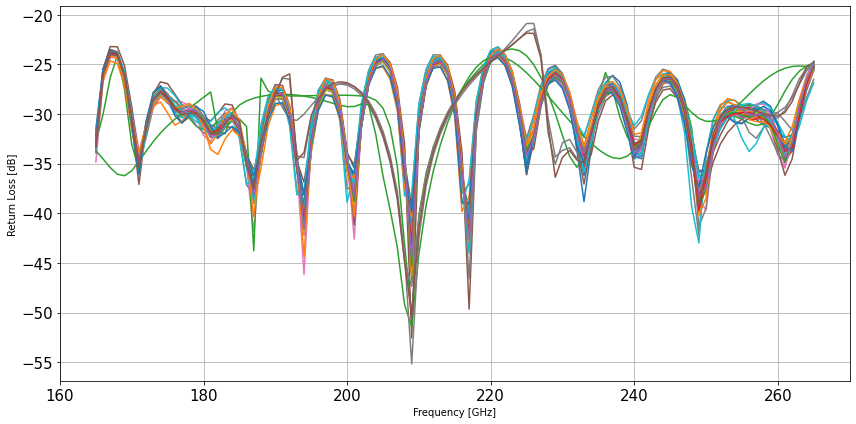

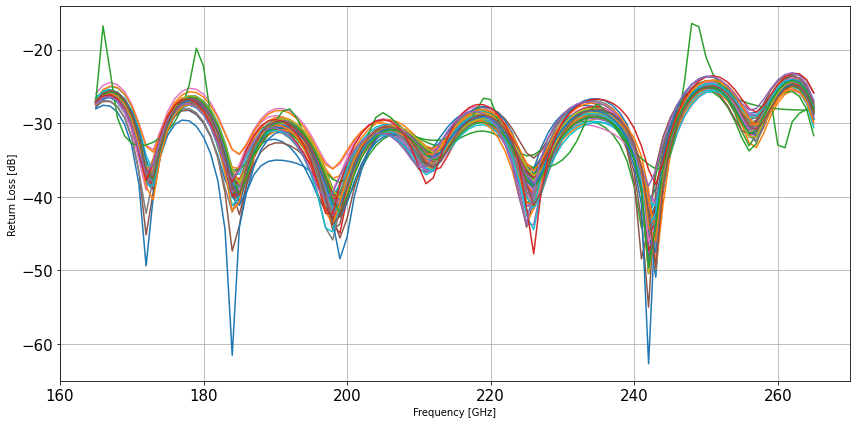

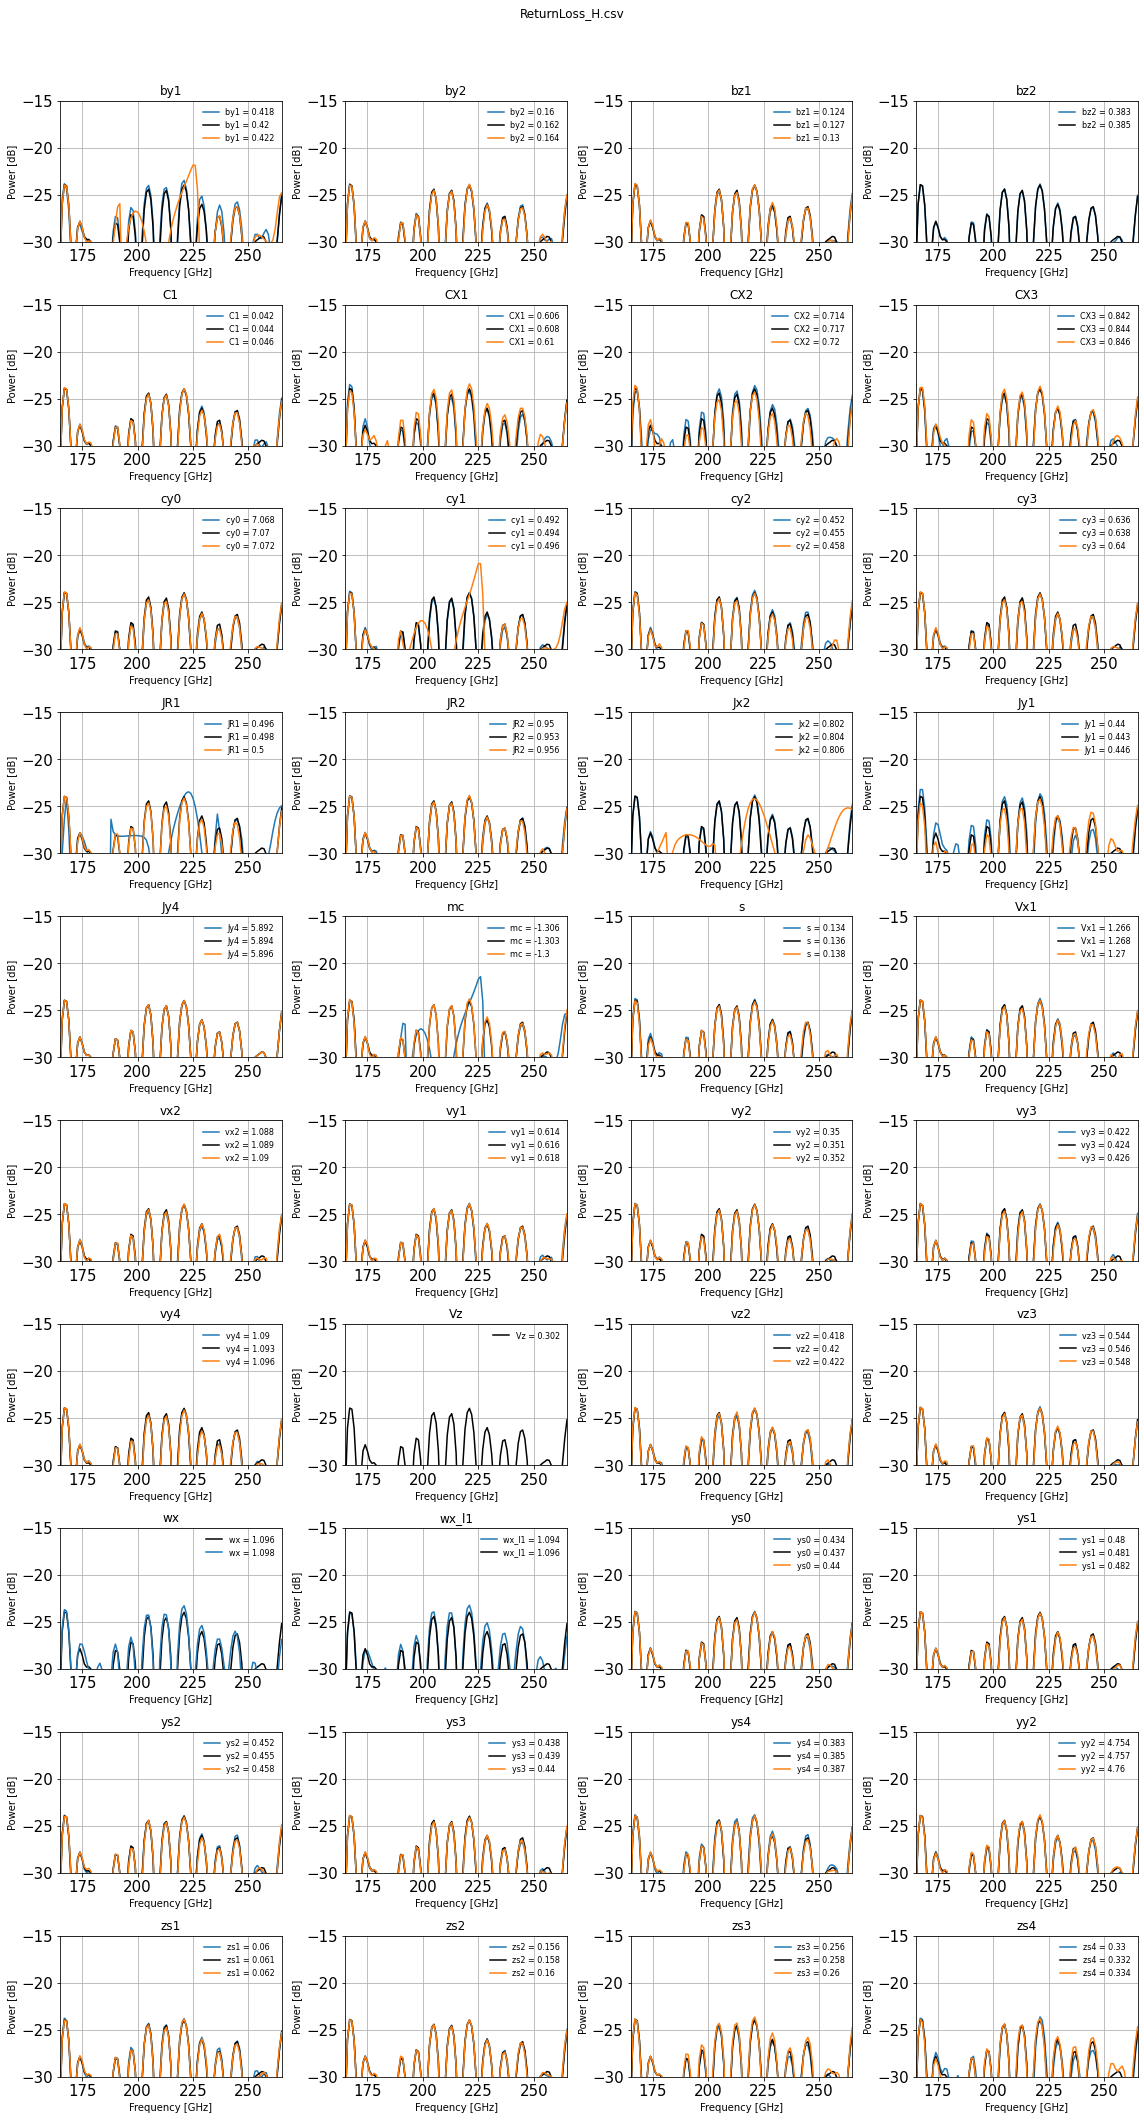

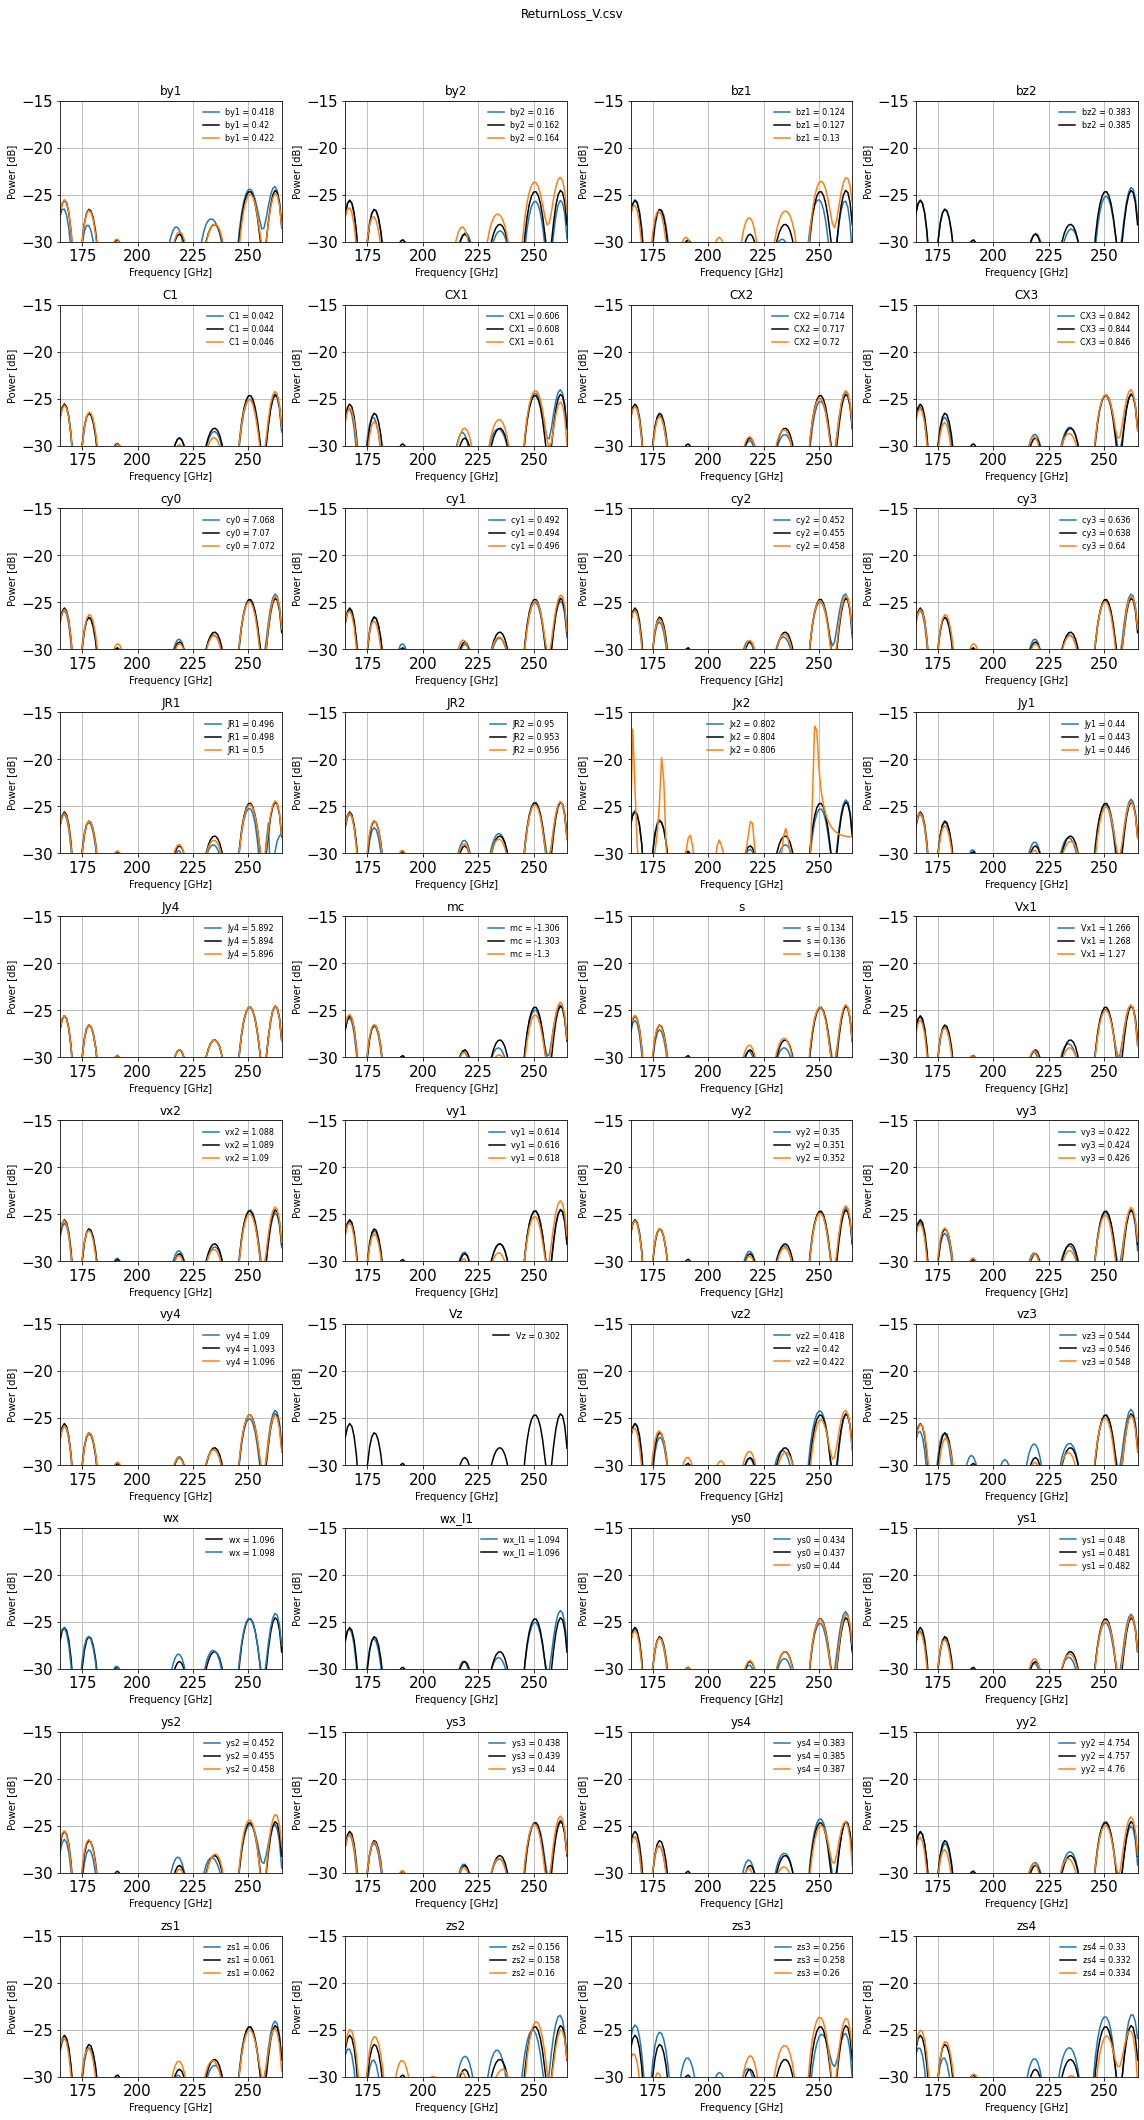

In [11]:
returns = separate_parset(data_list=data_list, inputfile_list=inputfile_list)

In [12]:
par_2Dlist, parset_2Dlist, freq_data_2Dlist, nominal_parset_list, nominal_freq_data_list, index_3Dlist, *tmp = returns
print(par_2Dlist)
print(freq_data_2Dlist[0][0])

[['by1', 'by2', 'bz1', 'bz2', 'C1', 'CX1', 'CX2', 'CX3', 'cy0', 'cy1', 'cy2', 'cy3', 'JR1', 'JR2', 'Jx2', 'Jy1', 'Jy4', 'mc', 's', 'Vx1', 'vx2', 'vy1', 'vy2', 'vy3', 'vy4', 'Vz', 'vz2', 'vz3', 'wx', 'wx_l1', 'ys0', 'ys1', 'ys2', 'ys3', 'ys4', 'yy2', 'zs1', 'zs2', 'zs3', 'zs4'], ['by1', 'by2', 'bz1', 'bz2', 'C1', 'CX1', 'CX2', 'CX3', 'cy0', 'cy1', 'cy2', 'cy3', 'JR1', 'JR2', 'Jx2', 'Jy1', 'Jy4', 'mc', 's', 'Vx1', 'vx2', 'vy1', 'vy2', 'vy3', 'vy4', 'Vz', 'vz2', 'vz3', 'wx', 'wx_l1', 'ys0', 'ys1', 'ys2', 'ys3', 'ys4', 'yy2', 'zs1', 'zs2', 'zs3', 'zs4']]
        by1    by2    bz1    bz2     C1    CX1    CX2    CX3   cy0    cy1  \
3434  0.418  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494   
3435  0.418  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494   
3436  0.418  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494   
3437  0.418  0.162  0.127  0.385  0.044  0.608  0.717  0.844  7.07  0.494   
3438  0.418  0.162  0.127  0.385  0.044  0.608  0.717  0.8

## Plot each parameter results

### Plot average power / max power in each parameter variations

========== ReturnLoss_H.csv =============
Paramters = ['by1', 'by2', 'bz1', 'bz2', 'C1', 'CX1', 'CX2', 'CX3', 'cy0', 'cy1', 'cy2', 'cy3', 'JR1', 'JR2', 'Jx2', 'Jy1', 'Jy4', 'mc', 's', 'Vx1', 'vx2', 'vy1', 'vy2', 'vy3', 'vy4', 'Vz', 'vz2', 'vz3', 'wx', 'wx_l1', 'ys0', 'ys1', 'ys2', 'ys3', 'ys4', 'yy2', 'zs1', 'zs2', 'zs3', 'zs4']
========== ReturnLoss_V.csv =============
Paramters = ['by1', 'by2', 'bz1', 'bz2', 'C1', 'CX1', 'CX2', 'CX3', 'cy0', 'cy1', 'cy2', 'cy3', 'JR1', 'JR2', 'Jx2', 'Jy1', 'Jy4', 'mc', 's', 'Vx1', 'vx2', 'vy1', 'vy2', 'vy3', 'vy4', 'Vz', 'vz2', 'vz3', 'wx', 'wx_l1', 'ys0', 'ys1', 'ys2', 'ys3', 'ys4', 'yy2', 'zs1', 'zs2', 'zs3', 'zs4']
Param. Diff. (max, mean) | ReturnLoss_H.csv      | ReturnLoss_V.csv      
--> by1 ReturnLoss_H.csv: [2.08588693 0.44940695] (max)
    by1 ReturnLoss_H.csv: [0.422 0.418]
--> by1 ReturnLoss_V.csv: [-0.32635745  0.40896621] (max)
    by1 ReturnLoss_V.csv: [0.422 0.418]
by1    Diff. (max) |       2.09|       0.41
--> by2 ReturnLoss_H.csv: 

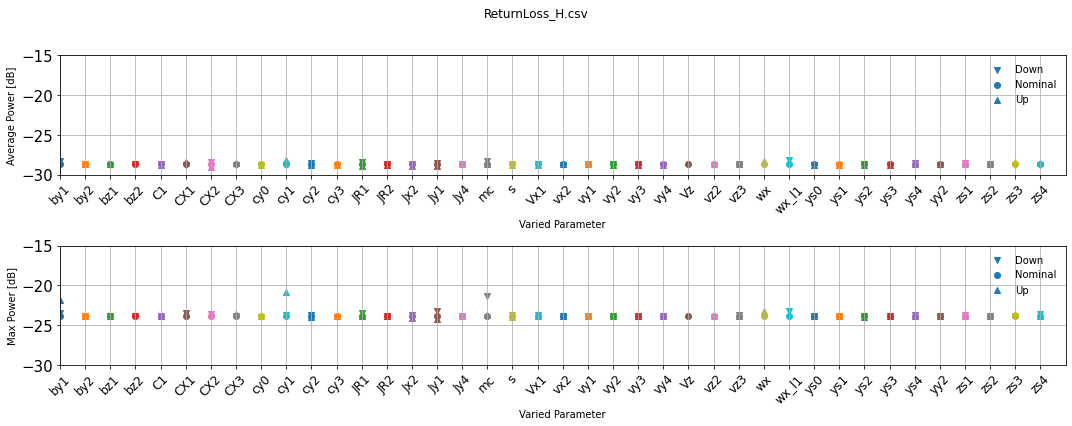

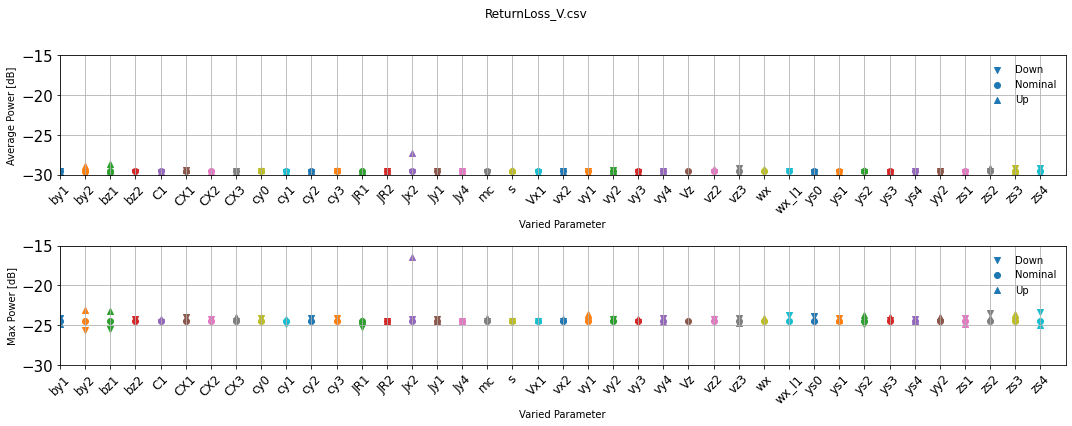

In [13]:
returns_pars = plot_parameters(freq_data_2Dlist=freq_data_2Dlist, 
                index_3Dlist=index_3Dlist, par_2Dlist=par_2Dlist, 
                parset_2Dlist=parset_2Dlist, 
                nominal_parset_list=nominal_parset_list, 
                inputfile_list=inputfile_list,
                showMean=False)

In [14]:
nominal_mean_list, nominal_max_list, diffs_3Dlist, *tmp = returns_pars
print(nominal_max_list)
print(nominal_mean_list)
print(diffs_3Dlist['max_down'])

[-23.9369415168895, -24.5514735609964]
[-28.69662891957872, -29.534388144314807]
[[[0.44940695499609973], [0.07894881922540264], [0.05629229494230259], [0.06989143740340253], [0.05510309579329942], [0.4338211503561027], [0.3192909289268009], [0.06636956828929996], [-0.01898742415049881], [0.13205432300150122], [0.22381061528350088], [-0.022853032062297274], [0.4891151316135023], [0.07298291292950054], [0.14770618691360227], [0.7328264120293007], [1.424620066359239e-08], [2.5154891534056], [0.17331384990690069], [0.19238877771229923], [0.05716150728060043], [0.09141423636230073], [0.09213307379510027], [0.08508480262100093], [0.012702802124699986], [], [-0.019964970579700037], [0.1433194469592003], [], [0.7165205456681996], [0.06923018242549972], [0.014582435974702435], [0.07317631461090102], [0.024799015173801564], [0.1203791667286005], [0.04607249401840008], [0.17600178219160156], [0.05380725183210089], [0.08023358915450274], [0.3000348935754005]], [[0.4089662078062979], [-1.051620415

### Show the best variables

========== ReturnLoss_H.csv =============
Paramters = ['by1', 'by2', 'bz1', 'bz2', 'C1', 'CX1', 'CX2', 'CX3', 'cy0', 'cy1', 'cy2', 'cy3', 'JR1', 'JR2', 'Jx2', 'Jy1', 'Jy4', 'mc', 's', 'Vx1', 'vx2', 'vy1', 'vy2', 'vy3', 'vy4', 'Vz', 'vz2', 'vz3', 'wx', 'wx_l1', 'ys0', 'ys1', 'ys2', 'ys3', 'ys4', 'yy2', 'zs1', 'zs2', 'zs3', 'zs4']
========== ReturnLoss_V.csv =============
Paramters = ['by1', 'by2', 'bz1', 'bz2', 'C1', 'CX1', 'CX2', 'CX3', 'cy0', 'cy1', 'cy2', 'cy3', 'JR1', 'JR2', 'Jx2', 'Jy1', 'Jy4', 'mc', 's', 'Vx1', 'vx2', 'vy1', 'vy2', 'vy3', 'vy4', 'Vz', 'vz2', 'vz3', 'wx', 'wx_l1', 'ys0', 'ys1', 'ys2', 'ys3', 'ys4', 'yy2', 'zs1', 'zs2', 'zs3', 'zs4']
== All average max ==
--pars = []--
pars = [] max = [-23.4875345618934, -24.1425073531901], mean = [-28.282120185721652, -29.513662188591105]
pars = [] max = [-23.8579926976641, -25.6030939760475], mean = [-28.670693632321118, -30.023806985036344]
pars = [] max = [-23.8806492219472, -25.5387729508551], mean = [-28.787829074087057, -30.1

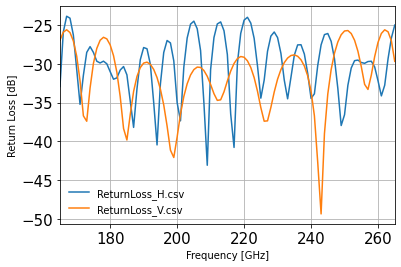

In [21]:
tmp = plot_best_parset(freq_data_2Dlist=freq_data_2Dlist, 
                index_3Dlist=index_3Dlist, par_2Dlist=par_2Dlist, 
                parset_2Dlist=parset_2Dlist, 
                nominal_parset_list=nominal_parset_list, 
                inputfile_list=inputfile_list,
                ignore_index_list=[], show_par_indices=[])

### Plot diff. in average power / max power in each parameter variations

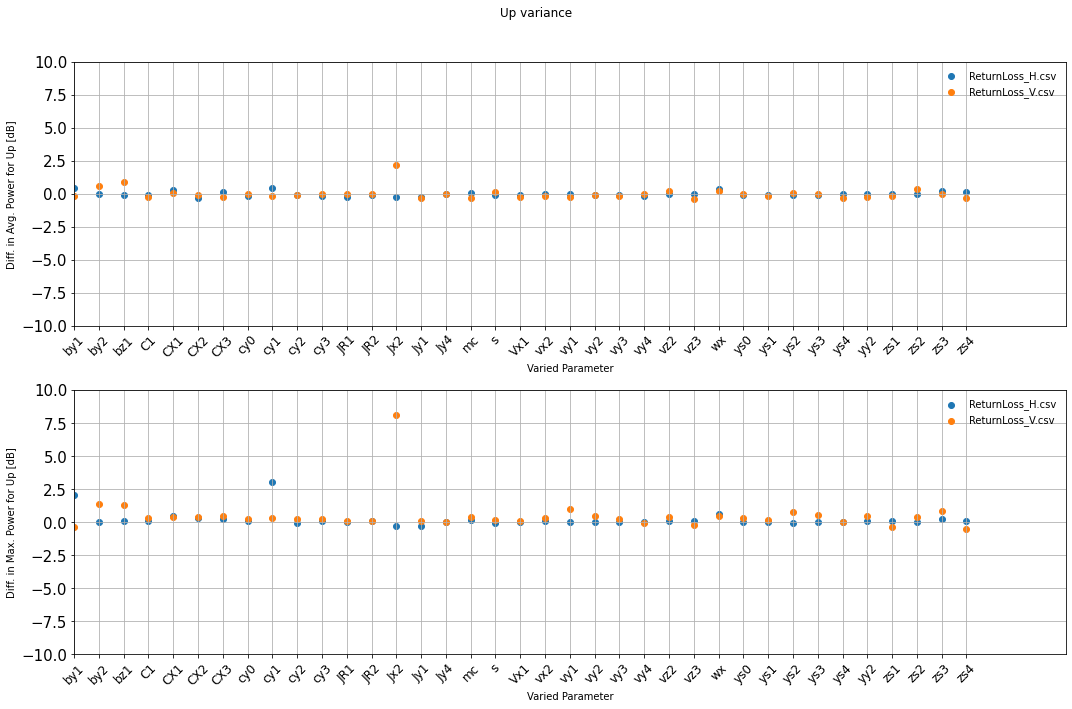

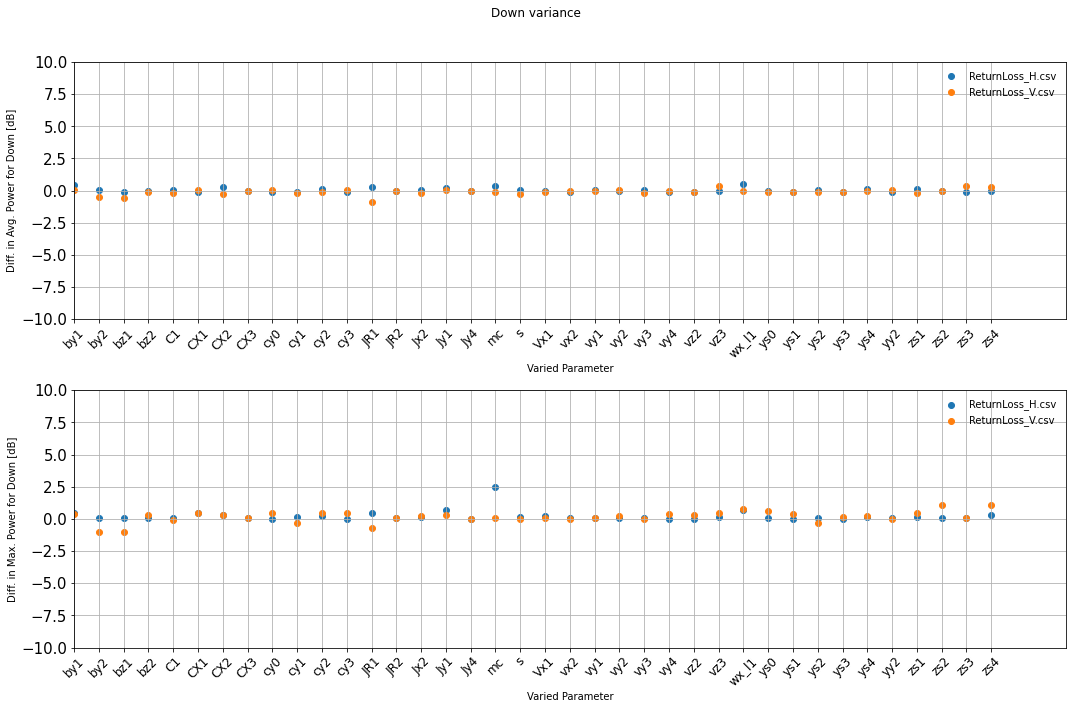

In [16]:
isImproves = plot_diff(inputfile_list=inputfile_list, par_2Dlist=par_2Dlist, diffs=diffs_3Dlist)

### Plot improve or not  in average power / max power in each parameter variations

0

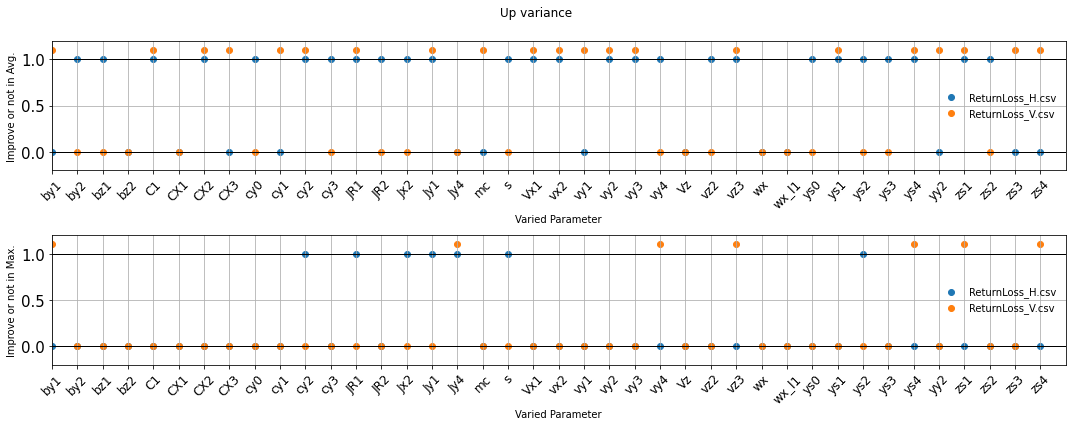

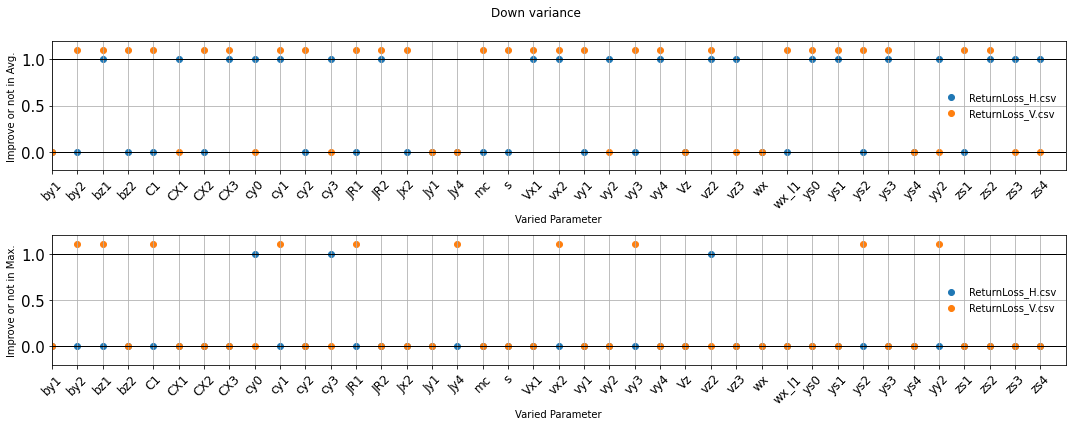

In [17]:
plot_isimprove(isUp=True, par_2Dlist=par_2Dlist, inputfile_list=inputfile_list, isImproves=isImproves)
plot_isimprove(isUp=False, par_2Dlist=par_2Dlist, inputfile_list=inputfile_list, isImproves=isImproves)

### Plot improve or not  in all input files

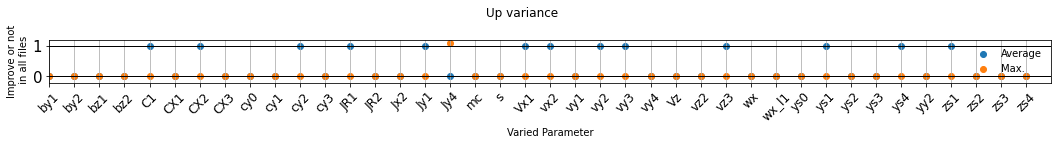

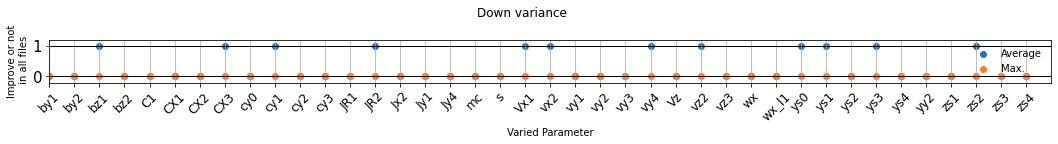

In [18]:
isImproveAND_up = plot_isimproveAND(isUp=True, par_2Dlist=par_2Dlist, isImproves=isImproves, inputfile_list=inputfile_list)
isImproveAND_down = plot_isimproveAND(isUp=False, par_2Dlist=par_2Dlist, isImproves=isImproves, inputfile_list=inputfile_list)

# Summary

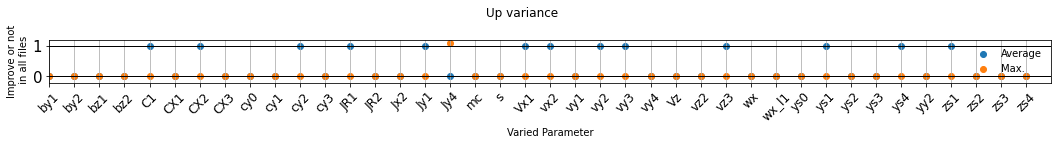

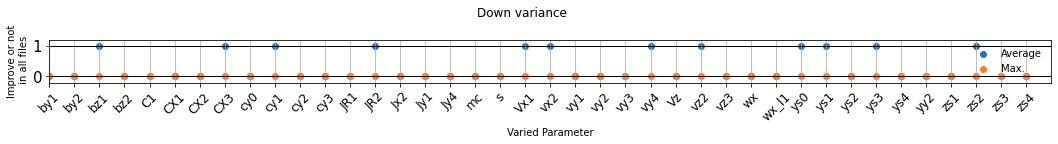

In [19]:
isImpAnd_up_1 = plot_isimproveAND(isUp=True, par_2Dlist=par_2Dlist, isImproves=isImproves, inputfile_list=inputfile_list)
isImpAnd_down_1 = plot_isimproveAND(isUp=False, par_2Dlist=par_2Dlist, isImproves=isImproves, inputfile_list=inputfile_list)

In [20]:
isImpAndMeanMax_up_1 = np.array(isImpAnd_up_1['mean']) & np.array(isImpAnd_up_1['max'])
isImpAndMeanMax_down_1 = np.array(isImpAnd_down_1['mean']) & np.array(isImpAnd_down_1['max'])
#print('npar', npar)

#print('i_list', i_list)
def show_improve_diff(isImprove, isUp=True, diffs_3Dlist=diffs_3Dlist, 
                      par_2Dlist=par_2Dlist, inputfile_list=inputfile_list, verbose=0):
    npar = len(par_2Dlist[0])
    i_list = np.arange(npar)[isImprove]
    if verbose > 0:
        print('npar', npar)
        print('isImprove: # = ', len(isImprove), 'sum = ', sum(isImprove))
        pass
    print(f'# of improved parameters: {len(i_list)} / {npar}')
    for i in i_list:
        _files = inputfile_list
        _par = par_2Dlist[0][i]
        if isUp:
            updown = 'up'
        else:
            updown = 'down'
            pass
        _diffs_mean = diffs_3Dlist['mean_'+updown]
        _diffs_max = diffs_3Dlist['max_'+updown]
        #print( len(_diffs_mean), len(_diffs_max) )
        output = f'{_par: ^5} {updown: ^4} (max, mean) [dB] /'
        for m, _file in enumerate(_files):
            _file = os.path.splitext(_file)[0]
            output += f' {_file: ^15} = ({_diffs_max[m][i][0]:6.2f}, {_diffs_mean[m][i][0]:6.2f}) /'
            pass
        print(output)
        pass
    return 0

print('== Nominal ==')
output = f'(max, mean) [dB] /'
for m, _file in enumerate(inputfile_list):
    _file = os.path.splitext(_file)[0]
    output += f' {_file: ^15} = ({nominal_max_list[m]:6.2f}, {nominal_mean_list[m]:6.2f}) /'
    pass
print(output)
print('== Current ==')
print(f'# of succeeeded analized parameter set = {len(freq_data_2Dlist[0])}')
show_improve_diff(isImpAndMeanMax_up_1, isUp=True, diffs_3Dlist=diffs_3Dlist, par_2Dlist=par_2Dlist, inputfile_list=inputfile_list)
show_improve_diff(isImpAndMeanMax_down_1, isUp=False, diffs_3Dlist=diffs_3Dlist, par_2Dlist=par_2Dlist, inputfile_list=inputfile_list)

impAndMeanMax_par_up_1 = np.array(par_2Dlist[0])[isImpAndMeanMax_up_1]
impAndMeanMax_par_down_1 = np.array(par_2Dlist[0])[isImpAndMeanMax_down_1]
print('== Current ==')
print(f'impoved in up   ({len(impAndMeanMax_par_up_1  )}) = {impAndMeanMax_par_up_1}')
print(f'impoved in down ({len(impAndMeanMax_par_down_1)}) = {impAndMeanMax_par_down_1}')

print('==== Merged between up & down ====')
impAndMeanMax_par_1 = np.hstack([impAndMeanMax_par_up_1, impAndMeanMax_par_down_1])
impAndMeanMax_par_1 = np.unique(impAndMeanMax_par_1)
print('== Current ==')
print(f'impoved ({len(impAndMeanMax_par_1  )}) = {impAndMeanMax_par_1.tolist()}')

#print('==== Next varing parameters ====')
#with open('new_scan_parameter_Design3_scan1-2.csv', 'w') as f:
#    for n, _par in enumerate(par_2Dlist2[0]):
#        _nominal = nominal_parset_list2[0]
#        if _par in impAndMeanMax_par:
#            _row = f'{_par:>5}, {_nominal[n]:6.3f}, y'
#            print(_row)
#            f.write(_row+'\n')
#        else:
#            _row = f'{_par:>5}, {_nominal[n]:6.3f}, n'
#            print(_row)
#            f.write(_row+'\n')
#            pass
#        pass

== Nominal ==
(max, mean) [dB] /  ReturnLoss_H   = (-23.94, -28.70) /  ReturnLoss_V   = (-24.55, -29.53) /
== Current ==
# of succeeeded analized parameter set = 76
# of improved parameters: 0 / 40
# of improved parameters: 0 / 40
== Current ==
impoved in up   (0) = []
impoved in down (0) = []
==== Merged between up & down ====
== Current ==
impoved (0) = []


# End